In [7]:
import pandas as pd
import numpy as np
import itertools as it
import scipy.sparse as sp

In [ ]:
#MAIN IDEA OF GRAPH BUILDING: 
#Getting items corresponding to each QueryID and having an edge between them

In [8]:
df = pd.read_pickle("../product_stats.pkl")
df_2 = pd.read_pickle("../query_item.pkl")

items = list(set(df_2["itemId"]))

features_df = df[df.itemId.isin(items)].drop("vector_gensim_product",axis=1).fillna(0)

In [9]:
query_IDs = df_2["queryId"].unique()
query_IDs.sort()

item_edges = []
for qid in query_IDs:
    df_queryID = df_2[df_2["queryId"] == qid]
    item_edges.append(list(it.combinations(df_queryID["itemId"],2)))

flat_edge_list = [item for sublist in item_edges for item in sublist]

In [10]:
features = features_df.values
node_features = sp.csr_matrix(features, dtype=np.float32)
edge_list = np.array(list(set(flat_edge_list)))

In [11]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [12]:
# build graph
idx = np.array(features[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
edges = np.array(list(map(idx_map.get, edge_list.flatten())),
                     dtype=np.int32).reshape(edge_list.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(features.shape[0], features.shape[0]),
                        dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
features = normalize(node_features)
adj = normalize(adj + sp.eye(adj.shape[0]))

In [23]:
sp.save_npz("graph_features.npz",features )
sp.save_npz("graph_adj.npz", adj)

In [ ]:
#steps done in AWS to get Graph Embedding using Graph Auto Encoders. 
#To modify number of iterations and use Graph Variational Auto Encoders to generate the embedding
#Source code for gae : https://github.com/tkipf/gae
#Made changes in gae code to get embeddings and not the TEST/TRAIN ROC. 

#!python setup.py install
#!cd gae/
#!python train.py 

#once this runs, stores embeddings in embedding.npy

In [16]:
#loading the Graph Embedding and checking
t = np.load('embedding.npy')
t.shape

(38084, 16)

In [14]:
#TSNE distrbution of product Graph based embeddings. to see if ay product clusters

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(t)

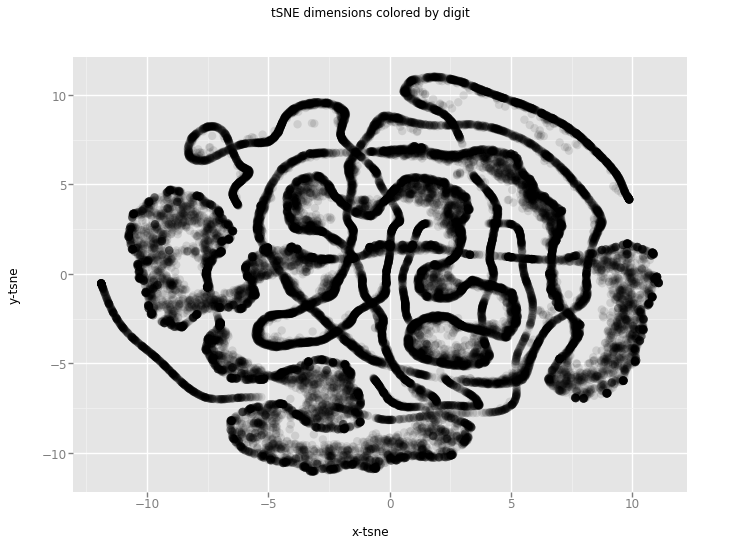

<ggplot: (-9223371876929273070)>

In [22]:
from ggplot import *

df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [ ]:
# TO DO:

#1) Method of building graph : 
    #Based on sessions ? 
    #Include weights if two products are connected multiple times, ie if two products co-occur in multiple queryIDs